In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, pdb, glob, time, fnmatch, datetime
from astropy.table import Table, vstack, hstack, Column, unique, join

def stop(): pdb.set_trace()

cat=Table.read('CatVisClass_AmberW_20220719.fits')


In [10]:
print(cat['objid','ra','dec', 'galb', 'candfilt','csig1', 'csig2', 'csig3', 'csig4', 'maxcsig', 'zphot', 'zphoterr','visclass1'])
ind_gal = np.where(cat['visclass1'] == 1)
cat_gal = cat[ind_gal]


  objid          ra               dec        ...  zphoterr  visclass1
--------- ---------------- ----------------- ... ---------- ---------
 96779812 9.39907076145174 0.280796771579759 ...   0.014018         1
116336777 7.57860095355787  4.18118656749963 ...   0.014018         1
111926761 7.73183384849052  3.51634213541818 ...   0.014018         1
 96782554 9.09170748419273 0.562168837963449 ...   0.014018         1
101515980  7.5357296875451  1.40929898214212 ... 0.00580527         1
111423945 5.19715191129701  3.98667284719778 ... 0.00580527         1
116335134 9.61372713266692  4.04166334876767 ...   0.011961         1
 96899021 0.58851683444832 0.937212214652352 ...  0.0139723         3
101518934 7.34061417524348  1.78037691424997 ... 0.00580527         1
101513848  6.8967700727345  1.16721684500626 ... 0.00580527         1
      ...              ...               ... ...        ...       ...
137894301 29.2051331220688  8.82121187313044 ...   0.011961         2
121590971 29.6950542

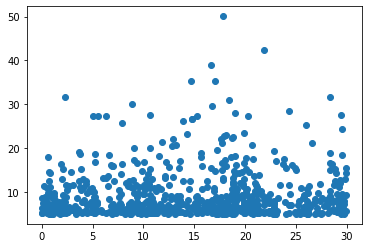

In [15]:
plt.scatter(cat['ra'][ind_gal], cat['maxcsig'][ind_gal])

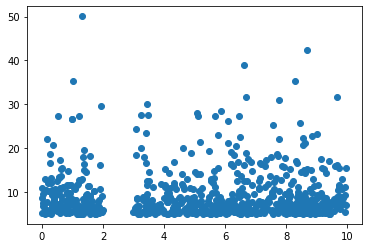

In [14]:
plt.scatter(cat['dec'][ind_gal], cat['maxcsig'][ind_gal])

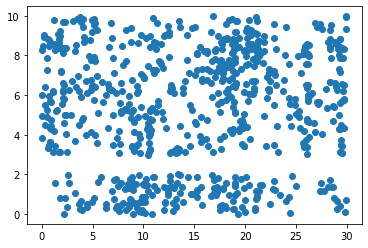

In [16]:
plt.scatter(cat['ra'][ind_gal], cat['dec'][ind_gal])